# Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q keras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional, TimeDistributed
from tensorflow.python.keras.layers import LSTM, Dense, Flatten, Permute, Reshape, Activation, add, GRU, MaxPooling1D, concatenate, GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.python.keras.layers import Dropout, ConvLSTM2D,Conv1D, Conv2D, MaxPooling2D, MaxPooling3D, AveragePooling2D, Input 
from tensorflow.python.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental import SyncBatchNormalization #Without tf.distribute strategy, this layer behaves as a regular tf.keras.layers.BatchNormalization layer....used to save model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, auc, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import scipy.io as sio



In [ ]:
# NN visualization
'''
from keras.utils import plot_model
plot_model(model, 'model.png')
'''
def model_plot(history):
  import matplotlib.pyplot as plt

  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.show()

## Test set accuracy and confusion
def results(preds,test_labelcat):
  y = np.argmax(test_labelcat,axis=1)
  yhat = np.argmax(preds,axis=1)
  print(accuracy_score(y,yhat))
  print(confusion_matrix(y,yhat))



# Office scene 

In [ ]:

train_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_melspec.npy')
valid_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_melspec.npy')
test_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_melspec.npy')

#source counting overall labels
train_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_sc_labels.npy')
valid_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_sc_labels.npy')
test_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_sc_labels.npy')

# speaker count labels
train_spk_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_spkc_labels.npy')
valid_spk_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_spkc_labels.npy')
test_spk_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_spkc_labels.npy')

# one hot encoding the labels
labels_sc = np.concatenate((train_sc_label,valid_sc_label,test_sc_label),axis=0)
labelscat = keras.utils.to_categorical(labels_sc-1) #subtract 1 because counting goes from 1-5, and we need categorical to start from 0
train_sc_labelcat = labelscat[0:len(train_sc_label),:]
valid_sc_labelcat = labelscat[len(train_sc_label):len(train_sc_label)+len(valid_sc_label),:]
test_sc_labelcat = labelscat[len(train_sc_label)+len(valid_sc_label):,:]

labels2 = np.concatenate((train_spk_label,valid_spk_label,test_spk_label),axis=0)
labels2cat = keras.utils.to_categorical(labels2) 
train_spk_labelcat = labels2cat[0:len(train_spk_label),:]
valid_spk_labelcat = labels2cat[len(train_spk_label):len(train_spk_label)+len(valid_spk_label),:]
test_spk_labelcat = labels2cat[len(train_spk_label)+len(valid_spk_label):,:]

In [ ]:
#to check categorical makes sense
print(train_sc_label[0])
print(train_sc_labelcat[0])

1
[1. 0. 0. 0. 0.]


In [ ]:
# reshape data to work with model dimensions
train = np.reshape(train_mel,(len(train_mel),train_mel[0].shape[0],train_mel[0].shape[1],1))
test = np.reshape(test_mel,(len(test_mel),test_mel[0].shape[0],test_mel[0].shape[1],1))
valid = np.reshape(valid_mel,(len(valid_mel),valid_mel[0].shape[0],valid_mel[0].shape[1],1))

input_this = Input(shape=(train[0].shape))

In [ ]:
numClasses = len(np.unique(train_sc_label))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]


y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
model.summary()


The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_1), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_1/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization_1/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda lay

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 431, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 429, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 214, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 31, 214, 8)   584         max_pooling2d[0][0]              
______________________________________________________________________________________________

Epoch 1/50
82/82 [==============================] - 62s 548ms/step - loss: 4.0483 - acc: 0.2577 - val_loss: 1.4224 - val_acc: 0.3340
Epoch 2/50
82/82 [==============================] - 43s 519ms/step - loss: 1.4038 - acc: 0.3579 - val_loss: 1.3202 - val_acc: 0.3870
Epoch 3/50
82/82 [==============================] - 43s 528ms/step - loss: 1.3228 - acc: 0.3915 - val_loss: 1.3299 - val_acc: 0.3750
Epoch 4/50
82/82 [==============================] - 44s 536ms/step - loss: 1.2840 - acc: 0.4071 - val_loss: 1.3109 - val_acc: 0.4020
Epoch 5/50
82/82 [==============================] - 44s 542ms/step - loss: 1.2466 - acc: 0.4327 - val_loss: 1.2104 - val_acc: 0.4360
Epoch 6/50
82/82 [==============================] - 45s 549ms/step - loss: 1.2304 - acc: 0.4423 - val_loss: 1.2259 - val_acc: 0.4420
Epoch 7/50
82/82 [==============================] - 45s 548ms/step - loss: 1.1887 - acc: 0.4606 - val_loss: 1.1275 - val_acc: 0.4790
Epoch 8/50
82/82 [==============================] - 45s 555ms/step - 

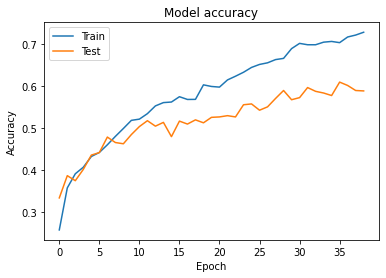

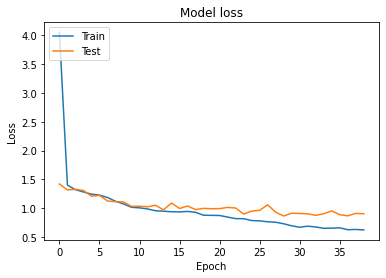

0.556
[[201   9   0   0   0]
 [ 30  97  81   2   0]
 [  5  32 108  55  10]
 [  1   6  74  96  33]
 [  0   1  21  84  54]]


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_sc_labelcat, validation_data=(valid,valid_sc_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history) #to plot the loss & acc over training

preds = model.predict(test)

results(preds, test_sc_labelcat)  #get confusion matrix and average accuracy

In [ ]:
y = np.argmax(test_sc_labelcat,axis=1)
yhat = np.argmax(preds,axis=1)
score=0
values, counts = np.unique(y, return_counts=True)
perclass_acc_plusminus1 = np.zeros(numClasses)
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
# PA1 accuracy metric
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/mins 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

Accuracy plus/minus 1 source counted is: 95.39999999999999
Per class accuracy plus/mins 1 source counted.
 Class Source count 1: 100.0
 Class Source count 2: 99.04761904761905
 Class Source count 3: 92.85714285714286
 Class Source count 4: 96.66666666666667
 Class Source count 5: 86.25


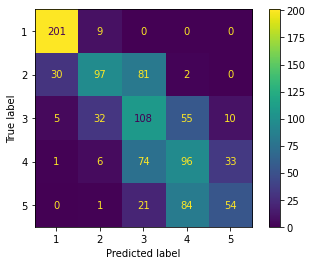

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y+1, yhat+1, labels = [1,2,3,4,5]) #give the true labels and predicted labels. '+1' so its the correct range of source count
plt.show()

In [ ]:
confusion_plusminus1 = np.zeros((numClasses,numClasses))
cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

Accuracy per class source count 1: 95.71428571428572%
Accuracy per class source count 2: 46.19047619047619%
Accuracy per class source count 3: 51.42857142857142%
Accuracy per class source count 4: 45.714285714285715%
Accuracy per class source count 5: 33.75%


## Office speaker counting

In [ ]:
numClasses = len(np.unique(train_spk_label))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]

res_34image = [64,64,64, 128,128,128,128, 256,256,256,256,256,256, 512,512,512]

# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
model.summary()


The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_35), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_35/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization_35/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_36), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_36/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization_36/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 431, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 62, 429, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 31, 214, 8)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 31, 214, 8)   584         max_pooling2d_1[0][0]            
____________________________________________________________________________________________

Epoch 1/50
82/82 [==============================] - 46s 519ms/step - loss: 6.0542 - acc: 0.3135 - val_loss: 1.7393 - val_acc: 0.2810
Epoch 2/50
82/82 [==============================] - 43s 523ms/step - loss: 1.3111 - acc: 0.3823 - val_loss: 1.2390 - val_acc: 0.4020
Epoch 3/50
82/82 [==============================] - 43s 530ms/step - loss: 1.1100 - acc: 0.4629 - val_loss: 1.1606 - val_acc: 0.4290
Epoch 4/50
82/82 [==============================] - 44s 534ms/step - loss: 1.0565 - acc: 0.5069 - val_loss: 1.0254 - val_acc: 0.5430
Epoch 5/50
82/82 [==============================] - 44s 540ms/step - loss: 0.9372 - acc: 0.5656 - val_loss: 0.8998 - val_acc: 0.6030
Epoch 6/50
82/82 [==============================] - 45s 545ms/step - loss: 0.8934 - acc: 0.5754 - val_loss: 0.8001 - val_acc: 0.6330
Epoch 7/50
82/82 [==============================] - 45s 549ms/step - loss: 0.8603 - acc: 0.5896 - val_loss: 0.8357 - val_acc: 0.5910
Epoch 8/50
82/82 [==============================] - 45s 548ms/step - 

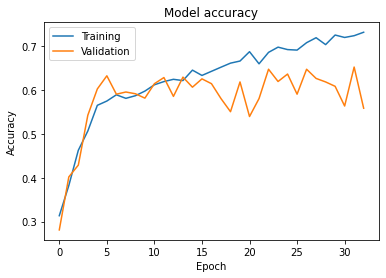

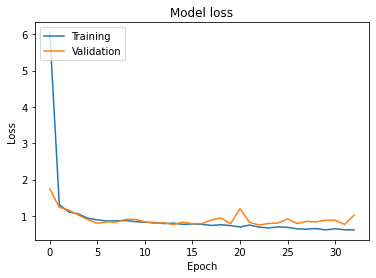

0.55
[[198   2   0   0   0]
 [  0  89  54  47  10]
 [  0  40  65  75  20]
 [  0  14  45  97  44]
 [  0   5  32  62 101]]


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_spk_labelcat, validation_data=(valid,valid_spk_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_spk_labelcat)  

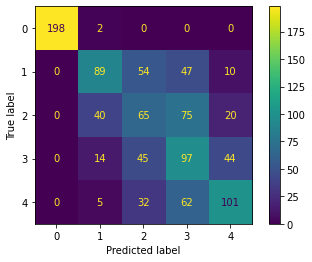

Accuracy per class source count 1: 99.0%
Accuracy per class source count 2: 44.5%
Accuracy per class source count 3: 32.5%
Accuracy per class source count 4: 48.5%
Accuracy per class source count 5: 50.5%
Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 87.2
Per class accuracy plus/mins 1 source counted.
 Class Source count 1: 100.0
 Class Source count 2: 71.5
 Class Source count 3: 90.0
 Class Source count 4: 93.0
 Class Source count 5: 81.5


In [ ]:
y = np.argmax(test_spk_labelcat,axis=1) 
yhat = np.argmax(preds,axis=1)
score=0
values, counts = np.unique(y, return_counts=True)
perclass_acc_plusminus1 = np.zeros(numClasses)

ConfusionMatrixDisplay.from_predictions(y, yhat, labels = [0,1,2,3,4]) #give the true labels and predicted labels. '+1' so its the correct range of source count
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/mins 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

# Nature Scene

In [ ]:

train_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_melspec.npy')
valid_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_melspec.npy')
test_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_melspec.npy')

#source counting overall labels
train_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_sc_labels.npy')
valid_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_sc_labels.npy')
test_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_sc_labels.npy')

# speaker count labels
train_spk_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_spkc_labels.npy')
valid_spk_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_spkc_labels.npy')
test_spk_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_spkc_labels.npy')

# one hot encoding the labels
labels_sc = np.concatenate((train_sc_label,valid_sc_label,test_sc_label),axis=0)
labelscat = keras.utils.to_categorical(labels_sc-1) #subtract 1 because counting begins from 1, and we need categorical to start from 0
train_sc_labelcat = labelscat[0:len(train_sc_label),:]
valid_sc_labelcat = labelscat[len(train_sc_label):len(train_sc_label)+len(valid_sc_label),:]
test_sc_labelcat = labelscat[len(train_sc_label)+len(valid_sc_label):,:]

labels2 = np.concatenate((train_spk_label,valid_spk_label,test_spk_label),axis=0)
labels2cat = keras.utils.to_categorical(labels2) 
train_spk_labelcat = labels2cat[0:len(train_spk_label),:]
valid_spk_labelcat = labels2cat[len(train_spk_label):len(train_spk_label)+len(valid_spk_label),:]
test_spk_labelcat = labels2cat[len(train_spk_label)+len(valid_spk_label):,:]

In [ ]:
train = np.reshape(train_mel,(len(train_mel),train_mel[0].shape[0],train_mel[0].shape[1],1))
test = np.reshape(test_mel,(len(test_mel),test_mel[0].shape[0],test_mel[0].shape[1],1))
valid = np.reshape(valid_mel,(len(valid_mel),valid_mel[0].shape[0],valid_mel[0].shape[1],1))

input_this = Input(shape=(train[0].shape))

In [ ]:
numClasses = len(np.unique(train_sc_label))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
model.summary()


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=20,restore_best_weights=True)
history = model.fit(train, train_sc_labelcat, validation_data=(valid,valid_sc_labelcat), batch_size=64, epochs=100, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_sc_labelcat)  

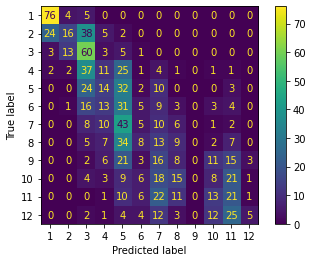

Accuracy per class source count 1: 89.41176470588236%
Accuracy per class source count 2: 18.823529411764707%
Accuracy per class source count 3: 70.58823529411765%
Accuracy per class source count 4: 12.941176470588237%
Accuracy per class source count 5: 37.64705882352941%
Accuracy per class source count 6: 5.88235294117647%
Accuracy per class source count 7: 11.76470588235294%
Accuracy per class source count 8: 10.588235294117647%
Accuracy per class source count 9: 0.0%
Accuracy per class source count 10: 9.411764705882353%
Accuracy per class source count 11: 24.705882352941178%
Accuracy per class source count 12: 7.352941176470589%

 Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 55.43369890329013
Per class accuracy plus/minus 1 source counted.
 Class Source count 1: 94.11764705882352
 Class Source count 2: 91.76470588235294
 Class Source count 3: 89.41176470588236
 Class Source count 4: 85.88235294117646
 Class Source count 5: 56.470588235294116
 Class Source count 6: 52

In [ ]:
y = np.argmax(test_sc_labelcat,axis=1)  #true labels
yhat = np.argmax(preds,axis=1) #predicted labels
score=0
values, counts = np.unique(y, return_counts=True) #'counts' to get the number of samples per class
perclass_acc_plusminus1 = np.zeros(numClasses) #variable to store per class accuracies plus/minus 1
labels_range = [*range(1,numClasses+1)]
ConfusionMatrixDisplay.from_predictions(y+1, yhat+1, labels = labels_range) #give the true labels and predicted labels. '+1' so its the correct range of source count problem where counting doesn't start at 0
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('\n Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/minus 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

## Nature speaker counting

In [ ]:
numClasses = len(np.unique(train_spk_label))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
#model.summary()


The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_105), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_105/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization_105/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.compat.v1.nn.fused_batch_norm_106), but
are not present in its tracked objects:
  <tf.Variable 'batch_normalization_106/gamma:0' shape=(8,) dtype=float32>
  <tf.Variable 'batch_normalization_106/beta:0' shape=(8,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were

Epoch 1/50
82/82 [==============================] - 46s 517ms/step - loss: 3.8088 - acc: 0.2525 - val_loss: 1.5534 - val_acc: 0.2941
Epoch 2/50
82/82 [==============================] - 42s 518ms/step - loss: 1.4444 - acc: 0.3212 - val_loss: 1.2147 - val_acc: 0.3739
Epoch 3/50
82/82 [==============================] - 43s 526ms/step - loss: 1.1984 - acc: 0.3939 - val_loss: 1.6080 - val_acc: 0.3230
Epoch 4/50
82/82 [==============================] - 44s 532ms/step - loss: 1.1696 - acc: 0.4384 - val_loss: 1.1761 - val_acc: 0.3888
Epoch 5/50
82/82 [==============================] - 44s 537ms/step - loss: 1.1444 - acc: 0.4405 - val_loss: 1.1198 - val_acc: 0.4576
Epoch 6/50
82/82 [==============================] - 44s 541ms/step - loss: 1.1060 - acc: 0.4811 - val_loss: 1.2002 - val_acc: 0.4257
Epoch 7/50
82/82 [==============================] - 45s 543ms/step - loss: 1.1106 - acc: 0.4753 - val_loss: 1.1688 - val_acc: 0.4706
Epoch 8/50
82/82 [==============================] - 45s 545ms/step - 

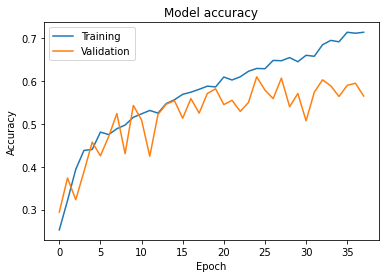

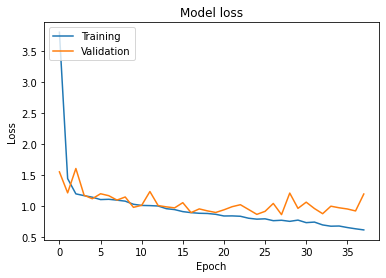

0.5114656031904287
[[186   0   0   1   0]
 [  0  51  75  55  23]
 [  1  28  86  67  22]
 [  0  25  44  79  56]
 [  0   9  33  51 111]]


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_spk_labelcat, validation_data=(valid,valid_spk_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_spk_labelcat)  

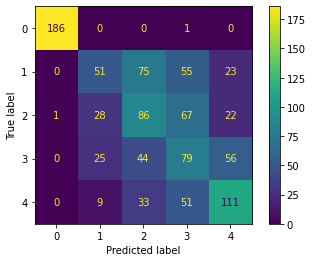

Accuracy per class source count 1: 99.46524064171123%
Accuracy per class source count 2: 25.0%
Accuracy per class source count 3: 42.15686274509804%
Accuracy per class source count 4: 38.72549019607843%
Accuracy per class source count 5: 54.41176470588235%
Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 83.1505483549352
Per class accuracy plus/mins 1 source counted.
 Class Source count 1: 99.46524064171123
 Class Source count 2: 61.76470588235294
 Class Source count 3: 88.72549019607843
 Class Source count 4: 87.74509803921569
 Class Source count 5: 79.41176470588235


In [ ]:
y = np.argmax(test_spk_labelcat,axis=1) 
yhat = np.argmax(preds,axis=1)
score=0
values, counts = np.unique(y, return_counts=True)
perclass_acc_plusminus1 = np.zeros(numClasses)

ConfusionMatrixDisplay.from_predictions(y, yhat, labels = [0,1,2,3,4]) #give the true labels and predicted labels. '+1' so its the correct range of source count
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/mins 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

# Overall speaker counting (joint office and nature scenes data)

In [ ]:
train_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_melspec.npy')
valid_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_melspec.npy')
test_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_melspec.npy')
train_spk_label_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_spkc_labels.npy')
valid_spk_label_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_spkc_labels.npy')
test_spk_label_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_spkc_labels.npy')

train_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_melspec.npy')
valid_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_melspec.npy')
test_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_melspec.npy')
train_spk_label_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_spkc_labels.npy')
valid_spk_label_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_spkc_labels.npy')
test_spk_label_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_spkc_labels.npy')

train_mel = np.concatenate((train_office, train_nature),axis=0)
valid_mel = np.concatenate((valid_office, valid_nature),axis=0)
test_mel = np.concatenate((test_office, test_nature),axis=0)

train_spk_labelcat = keras.utils.to_categorical(np.concatenate((train_spk_label_office, train_spk_label_nature),axis=0))
valid_spk_labelcat = keras.utils.to_categorical(np.concatenate((valid_spk_label_office, valid_spk_label_nature),axis=0))
test_spk_labelcat = keras.utils.to_categorical(np.concatenate((test_spk_label_office, test_spk_label_nature),axis=0))



In [ ]:
print(train_spk_label[0])
print(train_spk_label_office[0])

[1. 0. 0. 0. 0.]
0


In [ ]:
train = np.reshape(train_mel,(len(train_mel),train_mel[0].shape[0],train_mel[0].shape[1],1))
test = np.reshape(test_mel,(len(test_mel),test_mel[0].shape[0],test_mel[0].shape[1],1))
valid = np.reshape(valid_mel,(len(valid_mel),valid_mel[0].shape[0],valid_mel[0].shape[1],1))

input_this = Input(shape=(train[0].shape))

In [ ]:
numClasses = len(np.unique(train_spk_label_office))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
#model.summary()


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_spk_labelcat, validation_data=(valid,valid_spk_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_spk_labelcat)  

Epoch 1/50
163/163 [==============================] - 103s 524ms/step - loss: 4.1299 - acc: 0.3031 - val_loss: 1.1911 - val_acc: 0.3949
Epoch 2/50
163/163 [==============================] - 84s 516ms/step - loss: 1.1584 - acc: 0.4613 - val_loss: 1.0304 - val_acc: 0.5127
Epoch 3/50
163/163 [==============================] - 84s 516ms/step - loss: 1.1154 - acc: 0.4820 - val_loss: 1.2147 - val_acc: 0.4618
Epoch 4/50
163/163 [==============================] - 84s 515ms/step - loss: 1.0332 - acc: 0.5212 - val_loss: 0.9898 - val_acc: 0.5527
Epoch 5/50
163/163 [==============================] - 84s 516ms/step - loss: 1.0110 - acc: 0.5352 - val_loss: 1.0781 - val_acc: 0.5027
Epoch 6/50
163/163 [==============================] - 84s 517ms/step - loss: 0.9488 - acc: 0.5618 - val_loss: 0.9450 - val_acc: 0.5701
Epoch 7/50
163/163 [==============================] - 84s 517ms/step - loss: 0.9177 - acc: 0.5785 - val_loss: 1.0337 - val_acc: 0.5337
Epoch 8/50
163/163 [==============================] - 

NameError: ignored

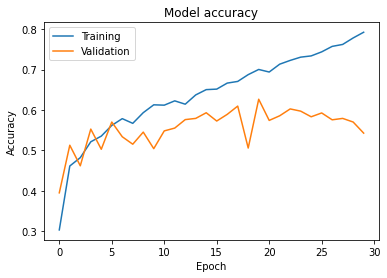

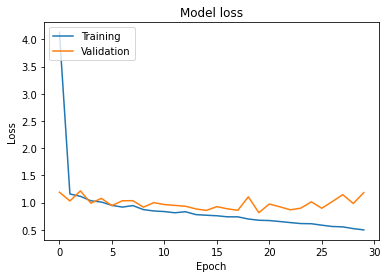

0.5187219171243135
[[384   2   1   0   0]
 [  0 178  93 119  14]
 [  0  83  87 216  18]
 [  0  48  60 245  51]
 [  1  51  35 172 145]]


In [ ]:
model_plot(history)

preds = model.predict(test)

results(preds, test_spk_labelcat) 

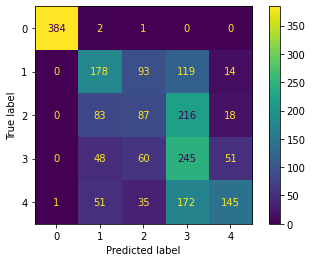

Accuracy per class source count 1: 99.2248062015504%
Accuracy per class source count 2: 44.05940594059406%
Accuracy per class source count 3: 21.534653465346533%
Accuracy per class source count 4: 60.64356435643564%
Accuracy per class source count 5: 35.89108910891089%
Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 85.67149276085871
Per class accuracy plus/mins 1 source counted.
 Class Source count 1: 99.74160206718346
 Class Source count 2: 67.07920792079209
 Class Source count 3: 95.54455445544554
 Class Source count 4: 88.11881188118812
 Class Source count 5: 78.46534653465346


In [ ]:
y = np.argmax(test_spk_labelcat,axis=1) 
yhat = np.argmax(preds,axis=1)
score=0
values, counts = np.unique(y, return_counts=True)
perclass_acc_plusminus1 = np.zeros(numClasses)

ConfusionMatrixDisplay.from_predictions(y, yhat, labels = [0,1,2,3,4]) #give the true labels and predicted labels. '+1' so its the correct range of source count
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/mins 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

# Urban Scene

In [ ]:

train_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_urban_melspec.npy')
valid_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_urban_melspec.npy')
test_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_urban_melspec.npy')

#source counting overall labels
train_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_urban_sc_labels.npy')
valid_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_urban_sc_labels.npy')
test_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_urban_sc_labels.npy')


# one hot encoding the labels
labels_sc = np.concatenate((train_sc_label,valid_sc_label,test_sc_label),axis=0)
labelscat = keras.utils.to_categorical(labels_sc-1) #subtract 1 because counting begins from 1, and we need categorical to start from 0
train_sc_labelcat = labelscat[0:len(train_sc_label),:]
valid_sc_labelcat = labelscat[len(train_sc_label):len(train_sc_label)+len(valid_sc_label),:]
test_sc_labelcat = labelscat[len(train_sc_label)+len(valid_sc_label):,:]


In [ ]:
train = np.reshape(train_mel,(len(train_mel),train_mel[0].shape[0],train_mel[0].shape[1],1))
test = np.reshape(test_mel,(len(test_mel),test_mel[0].shape[0],test_mel[0].shape[1],1))
valid = np.reshape(valid_mel,(len(valid_mel),valid_mel[0].shape[0],valid_mel[0].shape[1],1))

input_this = Input(shape=(train[0].shape))

In [ ]:
numClasses = len(np.unique(train_sc_label))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
#model.summary()


Epoch 1/50
82/82 [==============================] - 63s 537ms/step - loss: 4.0668 - acc: 0.2027 - val_loss: 1.7104 - val_acc: 0.2910
Epoch 2/50
82/82 [==============================] - 44s 532ms/step - loss: 1.8244 - acc: 0.2546 - val_loss: 3.5694 - val_acc: 0.1250
Epoch 3/50
82/82 [==============================] - 43s 531ms/step - loss: 1.7970 - acc: 0.2681 - val_loss: 1.7595 - val_acc: 0.2490
Epoch 4/50
82/82 [==============================] - 43s 526ms/step - loss: 1.6390 - acc: 0.2979 - val_loss: 1.6183 - val_acc: 0.3020
Epoch 5/50
82/82 [==============================] - 43s 528ms/step - loss: 1.6233 - acc: 0.3077 - val_loss: 1.7874 - val_acc: 0.2590
Epoch 6/50
82/82 [==============================] - 43s 526ms/step - loss: 1.5938 - acc: 0.3162 - val_loss: 1.6550 - val_acc: 0.2880
Epoch 7/50
82/82 [==============================] - 43s 526ms/step - loss: 1.5742 - acc: 0.3275 - val_loss: 1.7054 - val_acc: 0.3130
Epoch 8/50
82/82 [==============================] - 43s 526ms/step - 

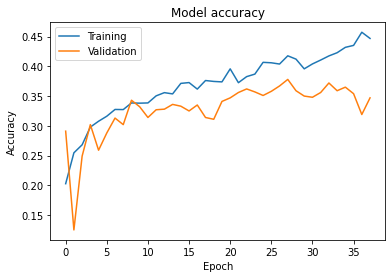

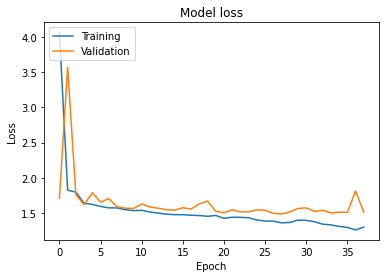

0.377
[[97 17 11  0  0  0  0  0]
 [29 54 31  4  3  4  0  0]
 [ 3 21 63 18 10  7  3  0]
 [ 0 12 38 18 20 29  4  4]
 [ 0  2 19 15 20 42  7 20]
 [ 0  0  2  7 28 55  3 30]
 [ 0  0  1  7 11 50 11 45]
 [ 0  0  0  1 14 46  5 59]]


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_sc_labelcat, validation_data=(valid,valid_sc_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_sc_labelcat)  

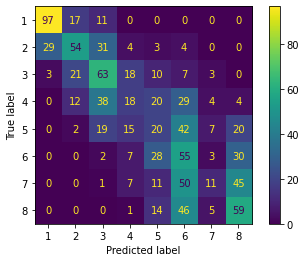

Accuracy per class source count 1: 77.60000000000001%
Accuracy per class source count 2: 43.2%
Accuracy per class source count 3: 50.4%
Accuracy per class source count 4: 14.399999999999999%
Accuracy per class source count 5: 16.0%
Accuracy per class source count 6: 44.0%
Accuracy per class source count 7: 8.799999999999999%
Accuracy per class source count 8: 47.199999999999996%

 Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 73.9
Per class accuracy plus/minus 1 source counted.
 Class Source count 1: 91.2
 Class Source count 2: 91.2
 Class Source count 3: 81.6
 Class Source count 4: 60.8
 Class Source count 5: 61.6
 Class Source count 6: 68.8
 Class Source count 7: 84.8
 Class Source count 8: 51.2


In [ ]:
y = np.argmax(test_sc_labelcat,axis=1)  #true labels
yhat = np.argmax(preds,axis=1) #predicted labels
score=0
values, counts = np.unique(y, return_counts=True) #'counts' to get the number of samples per class
perclass_acc_plusminus1 = np.zeros(numClasses) #variable to store per class accuracies plus/minus 1
labels_range = [*range(1,numClasses+1)] #getting a list of the number of possible source counts 
ConfusionMatrixDisplay.from_predictions(y+1, yhat+1, labels = labels_range) #give the true labels and predicted labels. '+1' so its the correct range of source count problem where counting doesn't start at 0
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('\n Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/minus 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

# Home Scene

In [ ]:

train_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_home_melspec.npy')
valid_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_home_melspec.npy')
test_mel = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_home_melspec.npy')

#source counting overall labels
train_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_home_sc_labels.npy')
valid_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_home_sc_labels.npy')
test_sc_label = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_home_sc_labels.npy')


# one hot encoding the labels
labels_sc = np.concatenate((train_sc_label,valid_sc_label,test_sc_label),axis=0)
labelscat = keras.utils.to_categorical(labels_sc-1) #subtract 1 because counting begins from 1, and we need categorical to start from 0
train_sc_labelcat = labelscat[0:len(train_sc_label),:]
valid_sc_labelcat = labelscat[len(train_sc_label):len(train_sc_label)+len(valid_sc_label),:]
test_sc_labelcat = labelscat[len(train_sc_label)+len(valid_sc_label):,:]


In [ ]:
train = np.reshape(train_mel,(len(train_mel),train_mel[0].shape[0],train_mel[0].shape[1],1))
test = np.reshape(test_mel,(len(test_mel),test_mel[0].shape[0],test_mel[0].shape[1],1))
valid = np.reshape(valid_mel,(len(valid_mel),valid_mel[0].shape[0],valid_mel[0].shape[1],1))

input_this = Input(shape=(train[0].shape))

In [ ]:
numClasses = len(np.unique(train_sc_label))


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
#model.summary()


Epoch 1/50
82/82 [==============================] - 50s 571ms/step - loss: 14.0320 - acc: 0.1406 - val_loss: 2.2128 - val_acc: 0.1471
Epoch 2/50
82/82 [==============================] - 42s 518ms/step - loss: 2.0842 - acc: 0.1802 - val_loss: 2.1485 - val_acc: 0.1682
Epoch 3/50
82/82 [==============================] - 43s 527ms/step - loss: 1.9540 - acc: 0.2232 - val_loss: 1.8696 - val_acc: 0.2673
Epoch 4/50
82/82 [==============================] - 43s 527ms/step - loss: 1.9248 - acc: 0.2232 - val_loss: 1.8924 - val_acc: 0.2382
Epoch 5/50
82/82 [==============================] - 43s 526ms/step - loss: 1.8929 - acc: 0.2351 - val_loss: 1.8819 - val_acc: 0.2543
Epoch 6/50
82/82 [==============================] - 43s 523ms/step - loss: 1.8674 - acc: 0.2380 - val_loss: 1.7694 - val_acc: 0.2823
Epoch 7/50
82/82 [==============================] - 43s 522ms/step - loss: 1.8161 - acc: 0.2557 - val_loss: 1.8248 - val_acc: 0.2733
Epoch 8/50
82/82 [==============================] - 43s 525ms/step -

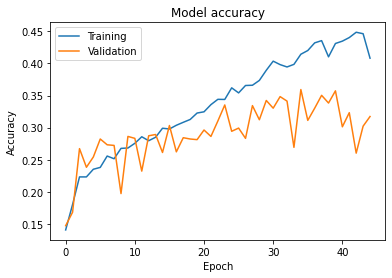

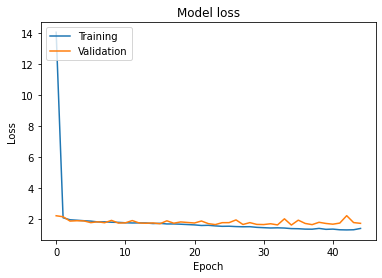

0.35835835835835833
[[95 13  0  2  0  1  0  0  0]
 [16 65  4 17  1  6  0  0  2]
 [ 4 37 13 31 10 12  0  0  4]
 [ 1 13  8 51 16 13  0  0  9]
 [ 0  6  1 25 28 31  0  3 17]
 [ 0  0  1 17 24 35  0  3 31]
 [ 0  1  1  8 12 41  0  6 42]
 [ 0  0  0  5  9 37  0  4 56]
 [ 0  1  0  5  3 30  0  5 67]]


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_sc_labelcat, validation_data=(valid,valid_sc_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_sc_labelcat)  

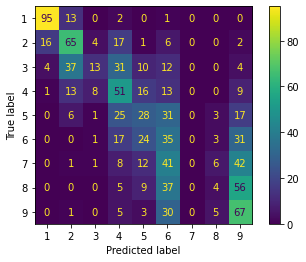

Accuracy per class source count 1: 85.58558558558559%
Accuracy per class source count 2: 58.55855855855856%
Accuracy per class source count 3: 11.711711711711711%
Accuracy per class source count 4: 45.94594594594595%
Accuracy per class source count 5: 25.225225225225223%
Accuracy per class source count 6: 31.53153153153153%
Accuracy per class source count 7: 0.0%
Accuracy per class source count 8: 3.6036036036036037%
Accuracy per class source count 9: 60.36036036036037%

 Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 67.16716716716716
Per class accuracy plus/minus 1 source counted.
 Class Source count 1: 97.2972972972973
 Class Source count 2: 76.57657657657657
 Class Source count 3: 72.97297297297297
 Class Source count 4: 67.56756756756756
 Class Source count 5: 75.67567567567568
 Class Source count 6: 53.153153153153156
 Class Source count 7: 42.34234234234234
 Class Source count 8: 54.054054054054056
 Class Source count 9: 64.86486486486487


In [ ]:
y = np.argmax(test_sc_labelcat,axis=1)  #true labels
yhat = np.argmax(preds,axis=1) #predicted labels
score=0
values, counts = np.unique(y, return_counts=True) #'counts' to get the number of samples per class
perclass_acc_plusminus1 = np.zeros(numClasses) #variable to store per class accuracies plus/minus 1
labels_range = [*range(1,numClasses+1)] #getting a list of the number of possible source counts 
ConfusionMatrixDisplay.from_predictions(y+1, yhat+1, labels = labels_range) #give the true labels and predicted labels. '+1' so its the correct range of source count problem where counting doesn't start at 0
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('\n Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/minus 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')

# Overall Source Counting 

In [ ]:
train_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_melspec.npy')
valid_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_melspec.npy')
test_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_melspec.npy')
train_sc_label_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_office_sc_labels.npy')
valid_sc_label_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_office_sc_labels.npy')
test_sc_label_office = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_office_sc_labels.npy')

train_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_melspec.npy')
valid_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_melspec.npy')
test_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_melspec.npy')
train_sc_label_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_nature_sc_labels.npy')
valid_sc_label_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_nature_sc_labels.npy')
test_sc_label_nature = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_nature_sc_labels.npy')

train_home = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_home_melspec.npy')
valid_home = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_home_melspec.npy')
test_home = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_home_melspec.npy')
train_sc_label_home = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_home_sc_labels.npy')
valid_sc_label_home = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_home_sc_labels.npy')
test_sc_label_home = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_home_sc_labels.npy')

train_urban = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_urban_melspec.npy')
valid_urban = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_urban_melspec.npy')
test_urban = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_urban_melspec.npy')
train_sc_label_urban = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/train_urban_sc_labels.npy')
valid_sc_label_urban = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/valid_urban_sc_labels.npy')
test_sc_label_urban = np.load('/content/drive/My Drive/ColabNotebooks/SARdBScene_features/test_urban_sc_labels.npy')

train_mel = np.concatenate((train_office, train_nature, train_home, train_urban),axis=0)
valid_mel = np.concatenate((valid_office, valid_nature, valid_home, valid_urban),axis=0)
test_mel = np.concatenate((test_office, test_nature, test_home, test_urban),axis=0)

train_sc_labelcat = keras.utils.to_categorical(np.concatenate((train_sc_label_office-1, train_sc_label_nature-1,
                                                                train_sc_label_home-1,
                                                                train_sc_label_urban-1),axis=0))
valid_sc_labelcat = keras.utils.to_categorical(np.concatenate((valid_sc_label_office-1, valid_sc_label_nature-1,
                                                                valid_sc_label_home-1,
                                                                valid_sc_label_urban-1),axis=0))
test_sc_labelcat = keras.utils.to_categorical(np.concatenate((test_sc_label_office-1, test_sc_label_nature-1,
                                                               test_sc_label_home-1,
                                                               test_sc_label_urban-1),axis=0))


In [ ]:
# delete used variable to free ram
del train_office
del train_nature
del train_home
del train_urban
del valid_nature
del valid_office
del valid_urban
del valid_home
del test_nature
del test_home
del test_urban
del test_office


In [ ]:
train = np.reshape(train_mel,(len(train_mel),train_mel[0].shape[0],train_mel[0].shape[1],1))
test = np.reshape(test_mel,(len(test_mel),test_mel[0].shape[0],test_mel[0].shape[1],1))
valid = np.reshape(valid_mel,(len(valid_mel),valid_mel[0].shape[0],valid_mel[0].shape[1],1))

input_this = Input(shape=(train[0].shape))

In [ ]:
del train_mel
del valid_mel
del test_mel


In [ ]:
numClasses = len(np.unique(train_sc_label_nature))#nature has the most classes


ins = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_this) 
ins = MaxPooling2D(pool_size=(2,2))(ins) 
res_filt = [8,8,8, 16,16,16,16, 32,32,32,32,32,32, 64,64,64]


# Residual block 
curr = res_filt[0]
for i,r in enumerate(res_filt):

  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(ins)  # first conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=res_filt[i], kernel_size=(3,3), padding='same')(x) #2nd conv
  x = SyncBatchNormalization()(x)
  x = Activation('relu')(x) 
  if res_filt[i]!=curr:
    ins = Conv2D(filters=res_filt[i],kernel_size=1,strides=1)(ins)
    ins = SyncBatchNormalization()(ins)
  ins = add([ins,x])  #add two outputs/inputs for residual. First residual block output
  curr = res_filt[i]

y = GlobalAveragePooling2D()(ins)
y = Dense(1000, activation='relu')(y)

out = Dense(numClasses, activation='softmax')(y) #for source counting

model = Model(input_this,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics='acc')
#model.summary()


Epoch 1/50
325/325 [==============================] - 188s 535ms/step - loss: 2.0485 - acc: 0.2377 - val_loss: 1.9782 - val_acc: 0.2306
Epoch 2/50
325/325 [==============================] - 175s 539ms/step - loss: 1.7777 - acc: 0.2879 - val_loss: 1.8729 - val_acc: 0.2806
Epoch 3/50
325/325 [==============================] - 177s 544ms/step - loss: 1.7227 - acc: 0.3084 - val_loss: 1.7317 - val_acc: 0.2919
Epoch 4/50
325/325 [==============================] - 177s 544ms/step - loss: 1.6210 - acc: 0.3420 - val_loss: 1.7005 - val_acc: 0.3263
Epoch 5/50
325/325 [==============================] - 177s 544ms/step - loss: 1.5711 - acc: 0.3586 - val_loss: 1.5377 - val_acc: 0.3556
Epoch 6/50
325/325 [==============================] - 177s 546ms/step - loss: 1.5294 - acc: 0.3737 - val_loss: 1.6202 - val_acc: 0.3508
Epoch 7/50
325/325 [==============================] - 177s 545ms/step - loss: 1.4920 - acc: 0.3802 - val_loss: 1.5175 - val_acc: 0.3708
Epoch 8/50
325/325 [============================

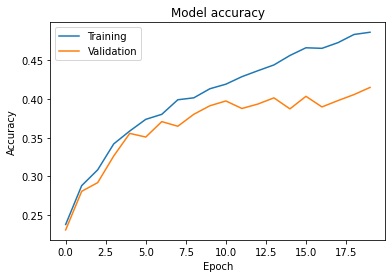

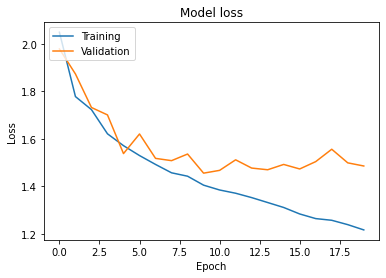

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


0.37306346826586706
[[407 106  15   1   1   0   0   0   1   0   0   0]
 [ 42 283 154  29  21   0   0   0   2   0   0   0]
 [  7 119 216  82  93   0  10   0   4   0   0   0]
 [  1  28 126 139 193   1  27   0  16   0   0   0]
 [  0   5  75  83 224   2  50   3  38   0   1   0]
 [  0   1  21  40 141   1  63   1  52   0   1   0]
 [  0   1  10  23 105   0 104   1  76   0   1   0]
 [  0   0   5  12  81   2 119   3  97   1   1   0]
 [  0   0   1   5  24   2  53   0 100   2   9   0]
 [  0   0   1   5  11   0  24   0  27   2  14   1]
 [  0   0   0   0   3   1  36   0  33   0  11   1]
 [  0   0   0   0   8   0  15   0  31   2   9   3]]


In [ ]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
history = model.fit(train, train_sc_labelcat, validation_data=(valid,valid_sc_labelcat), batch_size=64, epochs=50, callbacks=[es])

model_plot(history)

preds = model.predict(test)

results(preds, test_sc_labelcat)  

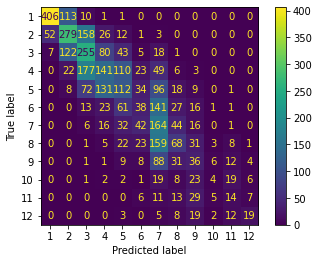

Accuracy per class source count 1: 76.45951035781545%
Accuracy per class source count 2: 52.54237288135594%
Accuracy per class source count 3: 48.0225988700565%
Accuracy per class source count 4: 26.55367231638418%
Accuracy per class source count 5: 23.284823284823286%
Accuracy per class source count 6: 11.838006230529595%
Accuracy per class source count 7: 51.09034267912772%
Accuracy per class source count 8: 21.18380062305296%
Accuracy per class source count 9: 18.367346938775512%
Accuracy per class source count 10: 4.705882352941177%
Accuracy per class source count 11: 16.470588235294116%
Accuracy per class source count 12: 27.941176470588236%

 Plus/minus 1 stats:
Accuracy plus/minus 1 source counted is: 77.31134432783608
Per class accuracy plus/minus 1 source counted.
 Class Source count 1: 97.74011299435028
 Class Source count 2: 92.09039548022598
 Class Source count 3: 86.06403013182674
 Class Source count 4: 80.60263653483992
 Class Source count 5: 57.58835758835759
 Class Sour

In [ ]:
y = np.argmax(test_sc_labelcat,axis=1)  #true labels
yhat = np.argmax(preds,axis=1) #predicted labels
score=0
values, counts = np.unique(y, return_counts=True) #'counts' to get the number of samples per class
perclass_acc_plusminus1 = np.zeros(numClasses) #variable to store per class accuracies plus/minus 1
labels_range = [*range(1,numClasses+1)] #getting a list of the number of possible source counts 
ConfusionMatrixDisplay.from_predictions(y+1, yhat+1, labels = labels_range) #give the true labels and predicted labels. '+1' so its the correct range of source count problem where counting doesn't start at 0
plt.show()

cm = confusion_matrix(y,yhat)

for i in range(len(cm)):
  print(f'Accuracy per class source count {i+1}: {cm[i,i]/np.sum(cm[i,:])*100}%')

print('\n Plus/minus 1 stats:')
for i in range(len(y)):
  plus1 = yhat[i]+1
  minus1 = yhat[i]-1
  if yhat[i]==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if plus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
  if minus1==y[i]:
    score=score+1
    perclass_acc_plusminus1[y[i]]+=1
accuracy_plusminus1 = score/len(y) *100
print(f'Accuracy plus/minus 1 source counted is: {accuracy_plusminus1}')
print('Per class accuracy plus/minus 1 source counted.')
for i in range(len(perclass_acc_plusminus1)):
  print(f' Class Source count {i+1}: {perclass_acc_plusminus1[i]/counts[i]*100}')